In [4]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from bilinear_interpolation import bilinear_interpolation
import xarray as xr

### Read dataframes 
> Climate data  
> Grid centres

In [5]:
src_path = r"W:/VUB/main_research/data/RMI"
os.chdir(src_path)

# Read gridded meteo data with encoding ISO-8859-1 since utf-8 doesnt work (try other encodings e.g. latin1, cp1252)
try:
    clim_data = pd.read_csv("pdg1487.csv", sep=";", header=0, encoding="ISO-8859-1")
except UnicodeDecodeError as e:
    print("ISO-8859-1 didn't work: ", e)

#read 5km by 5km grid
grid = pd.read_csv(src_path+"/gridded_data_docu/grid 5x5km_def.csv", sep=" ", skiprows=1)

##### Merge climate data with coordinate grid

In [6]:
#merge the two dataframes on pixel_id
climate_data_df = clim_data.merge(grid, on='PIXEL_ID')

#set date and pixel_id as index
climate_data_df.set_index(['DATE', 'PIXEL_ID'], inplace=True)

#sort the index
climate_data_df.sort_index(inplace=True)

#rename the columns to lower case
climate_data_df.columns = climate_data_df.columns.str.lower()

#calculate the mean temperature
climate_data_df['temperature mean (°c)']=0.5*(climate_data_df['temperature min (°c)'] + climate_data_df['temperature max (°c)'])

#extract climate variable names from the dataframe columns
climate_variables=['temperature max (°c)', 'temperature min (°c)','temperature mean (°c)', 'precipitation (mm)', 'et0 (mm)', 'global radiation (kwh/m2/day)', 'wind speed (m/s)']

In [7]:
climate_data_df["1994-01-01":"1994-01-01"].head()

pixel_lon_center  pixel_lat_center  temperature max (°c)  \
DATE       PIXEL_ID                                                             
1994-01-01 1                 5.419101         49.510015                   4.1   
           2                 5.488333         49.509469                   3.3   
           3                 5.557563         49.508882                   2.5   
           4                 5.626792         49.508253                   2.7   
           5                 5.419910         49.554969                   3.3   

                     temperature min (°c)  precipitation (mm)  et0 (mm)  \
DATE       PIXEL_ID                                                       
1994-01-01 1                          2.3                10.4       0.4   
           2                          2.4                10.0       0.4   
           3                          2.4                 9.6       0.4   
           4                          2.2                 9.7       0.4   
           5                          2.2                10.3       0.4   

                     global radiation (kwh/m2/day)  wind speed (m/s)  \
DATE       PIXEL_ID                                                    
1994-01-01 1                                  0.37               4.9   
           2                                  0.34               4.9   
           3                                  0.34               4.9   
           4                                  0.40               4.9   
           5                                  0.38               4.9   

                     lambert_x   lambert_y     lat    lon  \
DATE       PIXEL_ID                                         
1994-01-01 1             62500  6218014.18  49.510  5.419   
           2             67500  6218014.18  49.509  5.488   
           3             72500  6218014.18  49.509  5.558   
           4             77500  6218014.18  49.508  5.627   
           5             62500  6223014.18  49.555  5.420   

                     temperature mean (°c)  
DATE       PIXEL_ID                         
1994-01-01 1                          3.20  
           2                          2.85  
           3                          2.45  
           4                          2.45  
           5                          2.75

### Transform dataframe to gridded data

In [8]:
#STEPS
# create a date list..
#create a pivot table corresponding to each date..
#convert the data to a numpy array
#convert the array to a xarray dataset
#store the xarray datasets in a list and then concatenate them along the time dimension
#save the xarray dataset to a netcdf file

In [9]:
#gridded values
# Calculate step sizes based on resolution of the dataset
x_step = 5000  # Step size for x_in
y_step = 5000  # Step size for y_in

# Define input data grid, adjusting to include the pixel edges since the values are given at the center of the pixel
x_in = np.arange(climate_data_df["lambert_x"].min() - x_step / 2, climate_data_df["lambert_x"].max() + x_step, x_step) #np.arange is exclusive of the stop value so need to half the additional to the max values.
y_in = np.arange(climate_data_df["lambert_y"].min() - y_step / 2, climate_data_df["lambert_y"].max() + y_step, y_step)

#create a date list and #calculate length of data using the date index (level 0)
start_date = climate_data_df.index.levels[0][0]
len_data=len(climate_data_df.index.levels[0])
date_list = pd.date_range(start=start_date, periods=len_data, freq='D')


x_arr_variables = []
for variable in climate_variables:
    
    x_array_list = []
    for date, data in climate_data_df.groupby(level=0):
        #select the coordinates and convert to an np array
        data_grid=data.pivot_table(index='lambert_y', columns='lambert_x', values=variable)

        # Convert the grid to xarray DataArray using -1 aligns the values with the pixel edges up the second to last value
        daily_data_array = xr.DataArray(data_grid, coords=[y_in[:-1], x_in[:-1]], dims=['y', 'x'])

        # Append the DataArray to the list
        x_array_list.append(daily_data_array)

    # Concatenate the DataArrays along the time dimension
    x_data_array = xr.concat(x_array_list, dim='time')

    # Add the date list as a coordinate
    x_data_array['time'] = date_list

    #assign the variable name
    x_data_array.name = variable

    # Append the DataArray to the list
    x_arr_variables.append(x_data_array)

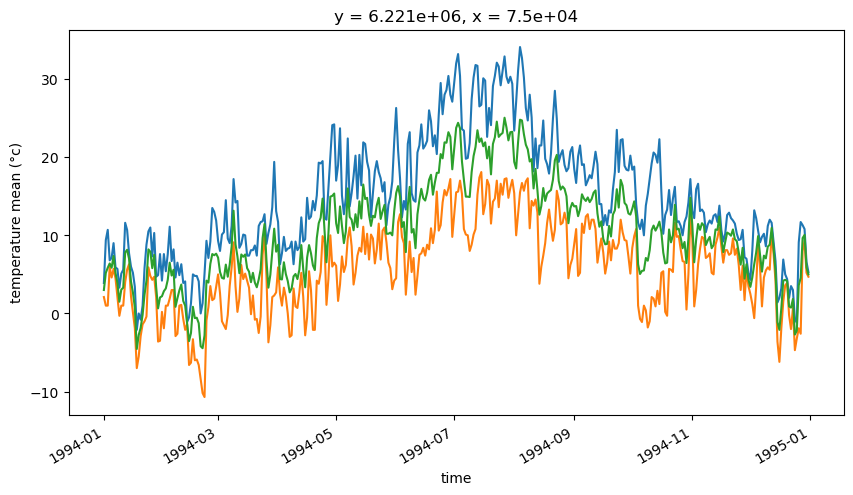

In [10]:
x_arr_variables[0][0:365].sel(y=6218014.18, x=72500, method='nearest').plot(figsize=(10, 5))
x_arr_variables[1][0:365].sel(y=6218014.18, x=72500, method='nearest').plot()
x_arr_variables[2][0:365].sel(y=6218014.18, x=72500, method='nearest').plot()

#### Check if points are correctly mapped

In [11]:
#search for a value at specific index   and check if the value is the same as the one in the dataframe
# Define the coordinates of the point of interest
x_point, y_point = 72500, 6218014.18

data_grid.columns.get_loc(x_point) #last variable in the loop
data_grid.index.get_loc(y_point)

data_grid.loc[y_point, x_point]
 #check if the value is the same as the one in the dataframe
# Filter the DataFrame for the specific latitude and longitude
df=climate_data_df.tail(1360) #select the last 1360 rows (values for the last date)

result = df[(df['lambert_x'] == x_point) & (df['lambert_y'] == y_point)]['wind speed (m/s)'].values[0]
result, data_grid.loc[y_point, x_point]

(5.1, 5.1)

In [12]:
date_list

DatetimeIndex(['1994-01-01', '1994-01-02', '1994-01-03', '1994-01-04',
               '1994-01-05', '1994-01-06', '1994-01-07', '1994-01-08',
               '1994-01-09', '1994-01-10',
               ...
               '2024-03-18', '2024-03-19', '2024-03-20', '2024-03-21',
               '2024-03-22', '2024-03-23', '2024-03-24', '2024-03-25',
               '2024-03-26', '2024-03-27'],
              dtype='datetime64[ns]', length=11044, freq='D')

#### (Optional) Bilinear interpolation

In [ ]:
# For the interpolated output grid, more refined
x_out_step = 2000  # Step for output grid
y_out_step = 2000

x_out = np.arange(x_in.min(),x_in.max()+x_out_step, x_out_step) #end exclusive
y_out = np.arange(y_in.max(),y_in.min()-y_out_step, -y_out_step) #reverse the y_out array to start from the top and - y_out_step to go down. End EXCLUSIVE

# Ensure f_in is the grid of values
f_in =data_grid

# Ensure bilinear_interpolation is defined to handle this grid setup correctly
f_out = bilinear_interpolation(x_in, y_in, f_in, x_out, y_out)

In [ ]:
# Visualizing the results using matplotlib
plt.subplots(1, 2, figsize=(10, 3.0))

plt.locator_params(axis="x", nbins=4)
# Plot original data as a mesh
plt.subplot(121)
plt.pcolormesh(x_in, y_in, f_in, cmap='rainbow')
plt.locator_params(axis="x", nbins=4)
plt.title('Original Data')
plt.grid(alpha=0.3)

# Plot interpolated data as a mesh
plt.subplot(122)
plt.pcolormesh(x_out, y_out, f_out, cmap='rainbow')
plt.title('Interpolated Data')
#set max divisions of x and y axis
#plt.locator_params(axis="x", nbins=4)
plt.grid(alpha=0.3)
plt.colorbar()

plt.show()

#### Export data array to netcdf

In [ ]:
#create a dictionary of the variables and the corresponding x arrays

#export the data array as a netcdf file
if not os.path.exists(r"W:/VUB/main_research/data/RMI/netcdf_files"):
    os.makedirs(r"W:/VUB/main_research/data/RMI/netcdf_files")

dest_dir=r"W:/VUB/main_research/data/RMI/netcdf_files"
original_data_array.to_netcdf(os.path.join(dest_dir,"tmax.nc"))